<a href="https://colab.research.google.com/github/armiro/Dental-Caries-Classification/blob/master/dental_caries_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import glob
import copy
import time

In [50]:
path = './drive/My Drive/small_caries_dataset/Healthy/**.jpg'
neg_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  img = fit_to_background(img)
  img = np.expand_dims(a=img, axis=-1)
  neg_images.append(img)

neg_images = np.array(neg_images)
print('num healthy images:', len(neg_images))

num healthy images: 238


In [51]:
path = './drive/My Drive/small_caries_dataset/Caries/**.jpg'
pos_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  img = fit_to_background(img)
  img = np.expand_dims(a=img, axis=-1)
  pos_images.append(img)

pos_images = np.array(pos_images)
print('num carious images:', len(pos_images))

num carious images: 45


In [52]:
num_iter = int(len(neg_images) / len(pos_images))-1
generated_pos_images = copy.deepcopy(x=pos_images)
for _ in range(num_iter):
  new_pos_images = copy.deepcopy(x=pos_images)
  generated_pos_images = np.concatenate((generated_pos_images, new_pos_images))

print('num repeated carious images:', len(generated_pos_images))

num repeated carious images: 225


In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range=30, zoom_range=[1., 2.], 
                         width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.15, horizontal_flip=True, 
                         vertical_flip=True, fill_mode='constant', cval=0.0)

In [0]:
'''data augmentation using albumentation functions'''

# from albumentations import Compose, HorizontalFlip, VerticalFlip

# def do_augmentation():
#   return Compose(transforms=[HorizontalFlip(always_apply=True), 
#                              VerticalFlip(always_apply=True)])

# aug_pos_images = list()
# for pos_img in generated_pos_images:
#   aug = do_augmentation()
#   img_dict = {'image': pos_img}
#   new_pos_img = aug(**img_dict)
#   new_pos_img = chain.from_iterable(new_pos_img.values())
#   new_pos_img = np.array(list(new_pos_img))
#   aug_pos_images.append(new_pos_img)

# aug_pos_images = np.array(aug_pos_images)
# pos_images = np.concatenate((generated_pos_images, aug_pos_images))

# aug_neg_images = list()
# for neg_img in neg_images:
#   aug = do_augmentation()
#   img_dict = {'image': neg_img}
#   new_neg_img = aug(**img_dict)
#   new_neg_img = chain.from_iterable(new_neg_img.values())
#   new_neg_img = np.array(list(new_neg_img))
#   aug_neg_images.append(new_pos_img)

# aug_neg_images = np.array(aug_neg_images)
# neg_images = np.concatenate((neg_images, aug_neg_images))

In [0]:
neg_labels = [0 for _ in range(len(neg_images))]
pos_labels = [1 for _ in range(len(generated_pos_images))]

In [55]:
X = np.concatenate((generated_pos_images, neg_images))
y = np.array(pos_labels + neg_labels)

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))

num total dataset images: 463
num total dataset labels: 463


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=21)

In [0]:
from keras import Model
inputA = Input(shape=pos_images[0].shape)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(inputA)
x1 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
x2 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x1)
x3 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x2)
x4 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x3)
x5 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x4)
x6 = Flatten()(x5)
x7 = Dense(units=10, activation='relu')(x6)
x8 = Dense(units=1, activation='sigmoid')(x7)
net = Model(inputs=inputA, outputs=x8)

In [79]:
net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
net.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 400, 400, 1)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 200, 200, 64)      640       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0   

In [80]:
t0 = time.time()

net.fit_generator(generator=aug.flow(x=X_train, y=y_train, batch_size=8), 
                  epochs=15, verbose=1)
# net.fit(x=X_train, y=y_train, batch_size=8, epochs=5, verbose=1)

t1 = time.time()
print('total training time: %.2f secs' % (round(t1-t0, ndigits=2)))

Epoch 1/15
47/47 [==============================] - 4s 85ms/step - loss: 0.8904 - acc: 0.4894
Epoch 2/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6991 - acc: 0.5052
Epoch 3/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6964 - acc: 0.5372
Epoch 4/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6925 - acc: 0.5346
Epoch 5/15
47/47 [==============================] - 4s 75ms/step - loss: 0.6955 - acc: 0.5371
Epoch 6/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6918 - acc: 0.5346
Epoch 7/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6925 - acc: 0.5346
Epoch 8/15
47/47 [==============================] - 4s 75ms/step - loss: 0.6916 - acc: 0.5717
Epoch 9/15
47/47 [==============================] - 4s 77ms/step - loss: 0.6920 - acc: 0.5239
Epoch 10/15
47/47 [==============================] - 4s 78ms/step - loss: 0.6914 - acc: 0.5239
Epoch 11/15
47/47 [==============================] - 4s 77m

In [81]:
from sklearn.metrics import confusion_matrix

# y_pred = net.predict(x=aug.flow(x=X_test, batch_size=8))
y_pred = net.predict(x=X_test)
y_test = np.reshape(a=y_test, newshape=(1, -1))

num_test_set = len(y_test[0])
print('num test-set images:', num_test_set)
print(y_test)
y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)))
print(y_pred)

cm = confusion_matrix(y_true=y_test[0], y_pred=y_pred[0])
print(cm)
print('test-set acc:', (cm[0][0] + cm[1][1])/np.sum(cm))

num test-set images: 93
[[1 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1
  1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0
  0 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 1 1]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[40  0]
 [53  0]]
test-set acc: 0.43010752688172044


In [0]:
'''fit the image to the background (when needed)'''
import cv2
def fit_to_background(image):
  image = image.squeeze()
  _, res = cv2.threshold(src=image, thresh=10, maxval=255, type=cv2.THRESH_BINARY)
  res = np.where(res>0, 255, 0).astype(np.uint8)
  _, cnts, _ = cv2.findContours(res, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
  x, y, w, h = cv2.boundingRect(cnts[0])
  image = image[y:y+h, x:x+w]
  image = cv2.resize(src=image, dsize=(400, 400))
  return image

In [0]:
img = X_test[-7]
plt.imshow(img.squeeze())
plt.show()
fitted_img = fit_to_background(image=img)
plt.imshow(fitted_img)
plt.show()
print(net.predict(img.reshape(1, img.shape[1], img.shape[0], -1)))

map generation time: 14.91 secs


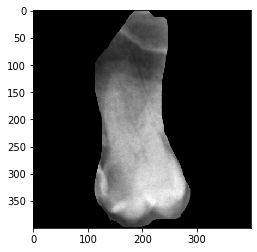

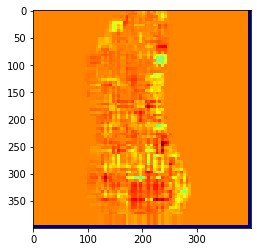

In [21]:
img = X_test[-7]
k_sz = 20
prob_map = np.zeros(shape=img.shape)
t0 = time.time()
for row_idx in range(0, img.shape[1]-k_sz, 5):
  for col_idx in range(0, img.shape[0]-k_sz, 5):
    masked = copy.deepcopy(x=img)
    masked[row_idx:row_idx+k_sz, col_idx:col_idx+k_sz] = 0
    prob = net.predict(x=masked.reshape(1, img.shape[0], img.shape[1], 1))
    prob_map[row_idx:row_idx+k_sz, col_idx:col_idx+k_sz] = 1 - prob

t1 = time.time()
print('map generation time: %.2f secs' % (round(t1-t0, ndigits=2)))
plt.imshow(img.squeeze(), cmap='gray')
plt.show()
plt.imshow(prob_map.squeeze(), cmap='jet')
plt.show()

In [0]:
net1 = Model(inputA, x3)
y_pred1 = net1.predict(x=X_test)
y_pred = net.predict(x=X_test)
# fig = plt.figure(figsize=(3, 3))
plt.imshow(X_test[1].squeeze())
plt.show()
for i in range(10):
  plt.imshow(y_pred1[1, :, :, i])
  plt.show()
print(y_test[0][1])
print(y_pred[1])

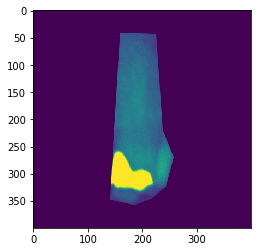

[ 0.         0.         0.         3.8754756  1.0161211  6.431295
  3.937914   1.8170772  0.        10.137731 ]
[0 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 0]
[0.00055698]


In [0]:
j = 8
net_dense = Model(inputA, x5)
y_dense = net_dense.predict(x=X_test)
y_pred = net.predict(x=X_test)

plt.imshow(X_test[j].squeeze())
plt.show()

print(y_dense[j])

print(y_test[0])
print(y_pred[j])